In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [4]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="../data/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

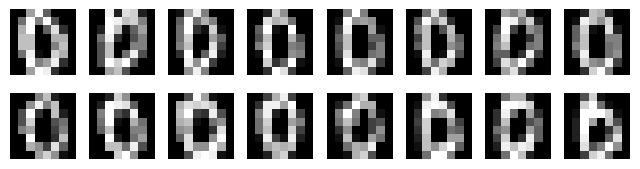

In [5]:
plt.figure(figsize=(8,2))

for i in range(16):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(2,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [6]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

In [8]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [10]:
noise = torch.rand(1, n_qubits)[0]
weights = torch.rand(1, n_qubits*q_depth)

In [11]:
test = partial_measure(noise, weights)
test

tensor([1.0000e+00, 5.9431e-04, 2.5947e-01, 8.5788e-05, 3.3723e-01, 1.2324e-02,
        1.9960e-02, 3.7139e-02, 6.3036e-03, 3.7459e-02, 1.8585e-01, 7.2829e-02,
        4.8840e-01, 1.2099e-02, 7.1022e-01, 5.4784e-02], dtype=torch.float64)

In [12]:
quantum_circuit(noise, weights)

tensor([2.2210e-01, 1.3200e-04, 5.7628e-02, 1.9053e-05, 7.4900e-02, 2.7372e-03,
        4.4331e-03, 8.2486e-03, 1.4000e-03, 8.3195e-03, 4.1278e-02, 1.6175e-02,
        1.0847e-01, 2.6871e-03, 1.5774e-01, 1.2167e-02, 8.1902e-02, 3.1037e-02,
        8.2124e-04, 1.3619e-02, 3.4094e-02, 8.0972e-03, 2.4383e-03, 1.2541e-03,
        9.2717e-05, 1.1136e-03, 3.8722e-04, 2.4475e-02, 2.1807e-02, 1.1812e-02,
        1.0997e-04, 4.8504e-02], dtype=torch.float64)

In [13]:
w = [
nn.Parameter(1 * torch.rand(q_depth * n_qubits), requires_grad=True)
for _ in range(1)
]

In [14]:
test = partial_measure(noise, w[0])
test

tensor([1.0000, 0.0212, 0.0151, 0.1596, 0.5647, 0.0035, 0.0266, 0.0153, 0.1798,
        0.0050, 0.5932, 0.0105, 0.0192, 0.1629, 0.8564, 0.0125],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [15]:
quantum_circuit(noise, w[0])

tensor([0.0979, 0.0021, 0.0015, 0.0156, 0.0553, 0.0003, 0.0026, 0.0015, 0.0176,
        0.0005, 0.0581, 0.0010, 0.0019, 0.0160, 0.0839, 0.0012, 0.0202, 0.0377,
        0.0164, 0.0003, 0.0059, 0.0485, 0.0126, 0.0129, 0.0984, 0.0006, 0.1167,
        0.0648, 0.0303, 0.0236, 0.1336, 0.0205], dtype=torch.float64,
       grad_fn=<ExecuteTapesBackward>)

In [16]:
partial_measure(noise, weights)

tensor([1.0000e+00, 5.9431e-04, 2.5947e-01, 8.5788e-05, 3.3723e-01, 1.2324e-02,
        1.9960e-02, 3.7139e-02, 6.3036e-03, 3.7459e-02, 1.8585e-01, 7.2829e-02,
        4.8840e-01, 1.2099e-02, 7.1022e-01, 5.4784e-02], dtype=torch.float64)

In [17]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** 4

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return q_out

In [18]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

noise = torch.rand(batch_size, n_qubits, device=device) * np.pi / 2
generator(noise)

tensor([[1.0000e+00, 8.0633e-03, 6.9434e-04, 7.7205e-01, 6.7970e-01, 1.1230e-04,
         3.2772e-03, 2.4840e-01, 1.3902e-02, 9.7226e-02, 2.4835e-01, 1.6914e-02,
         1.8131e-01, 2.8349e-01, 3.2619e-01, 8.3810e-02]],
       grad_fn=<UnsqueezeBackward0>)

In [19]:
[1.0000, 0.8990, 0.0520, 0.0234, 0.2556, 0.2338, 0.0302, 0.0096, 0.0439,
         0.0688, 0.0268, 0.0743, 0.0591, 0.0253, 0.2517, 0.4219]

[1.0,
 0.899,
 0.052,
 0.0234,
 0.2556,
 0.2338,
 0.0302,
 0.0096,
 0.0439,
 0.0688,
 0.0268,
 0.0743,
 0.0591,
 0.0253,
 0.2517,
 0.4219]

In [20]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [21]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

In [22]:
for param in generator.parameters():
    print(param)

Parameter containing:
tensor([0.2883, 0.6526, 0.2870, 0.3356, 0.2935, 0.9299, 0.9232, 0.1100, 0.3457,
        0.9529, 0.4712, 0.2566, 0.5605, 0.8956, 0.4364, 0.0282, 0.3329, 0.7488,
        0.4261, 0.8533, 0.6720, 0.5044, 0.6910, 0.4325, 0.0714, 0.0715, 0.1067,
        0.4204, 0.1385, 0.5733], requires_grad=True)
Parameter containing:
tensor([0.5573, 0.8804, 0.5281, 0.5852, 0.6778, 0.3586, 0.2509, 0.0297, 0.0130,
        0.5329, 0.2636, 0.6384, 0.6243, 0.8900, 0.4390, 0.4979, 0.8451, 0.5848,
        0.7288, 0.2300, 0.1386, 0.8812, 0.8564, 0.3107, 0.5831, 0.0553, 0.5350,
        0.0358, 0.7826, 0.0044], requires_grad=True)
Parameter containing:
tensor([0.3794, 0.9665, 0.3306, 0.2102, 0.9511, 0.2471, 0.6103, 0.7794, 0.6343,
        0.1546, 0.9538, 0.7398, 0.1856, 0.2146, 0.3847, 0.6668, 0.6891, 0.5644,
        0.8279, 0.9974, 0.6029, 0.6958, 0.7843, 0.5991, 0.5308, 0.9496, 0.8452,
        0.8266, 0.3054, 0.2609], requires_grad=True)
Parameter containing:
tensor([0.2289, 0.0813, 0.4492, 0

In [23]:
for i, (data, _) in enumerate(dataloader):

    # Data for training the discriminator
    data = data.reshape(-1, image_size * image_size)
    real_data = data.to(device)

real_data.shape

torch.Size([1, 64])

In [24]:


# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x16 and 64x64)

In [ ]:
for param in generator.parameters():
    print(param)

Parameter containing:
tensor([ 0.8965,  1.5346,  1.1739,  0.5581,  0.6474,  0.7375,  0.0723,  0.1678,
         0.9114, -0.0042,  0.1545,  0.3780,  0.8425,  0.4234,  0.4290,  0.3908,
         0.4209,  0.3999,  0.6989,  0.5337, -0.0519,  0.1579,  1.1863,  0.3636,
        -0.2011,  0.4190,  1.1580,  1.1357,  0.5770,  0.5736],
       requires_grad=True)
Parameter containing:
tensor([ 1.2320,  0.3820,  0.5327,  0.3017,  1.3221,  0.8679, -0.1636,  1.6013,
        -0.2612,  1.0134,  1.2653,  0.5373,  0.6283,  1.0717,  1.0293,  0.9331,
         0.0312,  0.6665,  0.6271,  0.7190,  0.7228,  0.6159,  0.6660,  0.7462,
         0.2783,  0.9227,  0.0773,  1.2686,  1.3355,  0.6546],
       requires_grad=True)
Parameter containing:
tensor([ 0.7602,  0.7145, -0.1807, -0.0527,  0.1401,  0.6839,  0.6255,  0.2916,
         1.1195, -0.1339,  0.4633,  0.4839,  0.2088,  0.3509,  0.5185,  0.1763,
         0.7493,  0.4821,  0.3385,  0.0588,  0.9092, -0.2557,  1.4209, -0.0452,
         0.1473,  0.5826,  1.5477,

In [ ]:
noise = torch.rand(batch_size, n_qubits)
print(noise.requires_grad)
t = generator(noise)
t

False


tensor([[8.2773e-03, 1.5813e-01, 2.1151e-02, 1.4304e-02, 4.9937e-02, 5.4621e-02,
         5.8329e-01, 2.6651e-02, 1.0991e-01, 4.7930e-04, 3.9779e-02, 2.2647e-02,
         4.2315e-02, 4.2574e-02, 1.0000e+00, 1.5131e-01, 5.9614e-02, 5.8319e-02,
         3.1726e-01, 1.6341e-03, 7.8938e-02, 1.8519e-01, 1.0000e+00, 1.9003e-02,
         3.4134e-04, 1.4622e-02, 1.0678e-02, 1.6215e-03, 1.9407e-02, 2.1762e-02,
         1.9632e-01, 1.2972e-03, 2.7920e-01, 7.2447e-02, 1.9879e-01, 1.9214e-02,
         2.4783e-02, 6.4129e-03, 1.0676e-01, 1.0345e-02, 3.2382e-01, 1.1852e-01,
         1.4421e-01, 8.4289e-03, 1.0203e-01, 7.7686e-03, 1.0000e+00, 1.5941e-01,
         1.0862e-01, 8.4128e-03, 1.0877e-01, 5.5639e-04, 2.1878e-01, 2.1922e-04,
         7.1558e-02, 2.6899e-02, 5.3432e-01, 3.2440e-02, 4.6412e-01, 2.0511e-02,
         6.3658e-05, 4.4729e-03, 1.0000e+00, 1.9760e-02]],
       grad_fn=<CatBackward0>)

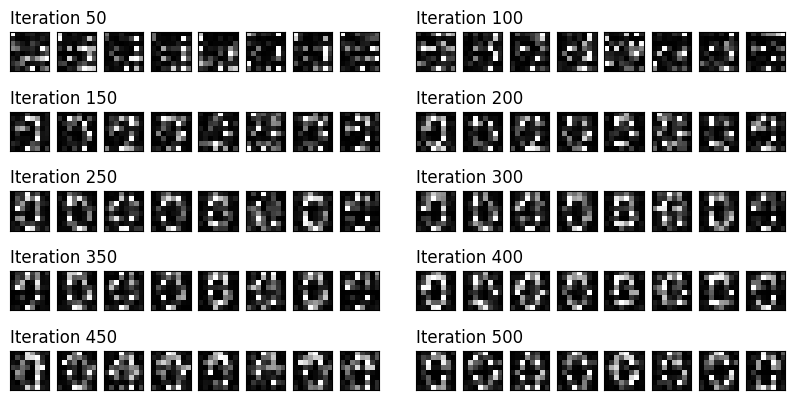

In [ ]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()